In [2]:
import os
import numpy as np 
import pandas as pd 
import cv2 
import random
import h5py

import matplotlib.pyplot as plt  
import matplotlib.image as mpimg
import seaborn as sns
from PIL import Image
from IPython.display import Image, SVG
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow
import keras
from keras import layers, models, optimizers
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model, model_to_dot
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import img_to_array, load_img
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras.preprocessing import image 
from keras.layers.normalization import BatchNormalization

In [3]:
# Set Constant Values
num_train = 1000
num_test = 1000
img_width = 224
img_height = 224
batch_size = 5
nb_epochs = 10

In [4]:
train_path = r'C:\Users\rizminawaz\Downloads\state-farm-distracted-driver-detection\imgs\train'
test_path = r'C:\Users\rizminawaz\Downloads\state-farm-distracted-driver-detection\imgs\test'
classes = ['c0','c1','c2','c3','c4','c5','c6','c7','c8','c9']
driver_img_list = r'C:\Users\rizminawaz\Downloads\state-farm-distracted-driver-detection\driver_imgs_list.csv'
# read image csv file
img_list = pd.read_csv(driver_img_list)
print(img_list.head())

  subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg


In [5]:
train_image = []
image_label = []

for category in classes:
    i=0
    path = os.path.join(train_path,category)
    for img in os.listdir(path):
           i+=1
    print('Numer of instances of class {} in Train: {}'.format(category, i))

i=0
for img in os.listdir(test_path):
    i+=1
print('\nTotal number of images in Test: ', i)

Numer of instances of class c0 in Train: 2489
Numer of instances of class c1 in Train: 2267
Numer of instances of class c2 in Train: 2317
Numer of instances of class c3 in Train: 2346
Numer of instances of class c4 in Train: 2326
Numer of instances of class c5 in Train: 2312
Numer of instances of class c6 in Train: 2325
Numer of instances of class c7 in Train: 2002
Numer of instances of class c8 in Train: 1911
Numer of instances of class c9 in Train: 2129

Total number of images in Test:  79726


In [9]:
training_data = []
testing_data = []

In [10]:
def create_training_data():
    for category in classes:
        i=0
        path = os.path.join(train_path,category)
        class_num = classes.index(category)
        for img in os.listdir(path):
            # return num_train instances of each class
            if i < num_train:
                img_array = cv2.imread(os.path.join(path,img))
                # resize image
                new_img = cv2.resize(img_array,(img_width,img_height), cv2.INTER_LINEAR)
                # get image and class type
                training_data.append([new_img, class_num])
                i+=1
    return training_data

In [11]:
def create_testing_data():
    i=0
    for img in os.listdir(test_path):
        # return num_test test images
        if i < num_test:
            img_array = cv2.imread(os.path.join(test_path,img))
            new_img = cv2.resize(img_array,(img_width,img_height), cv2.INTER_LINEAR)
            testing_data.append([img, new_img])
            i+=1
    return testing_data

In [12]:
testing_data = create_testing_data()

In [13]:
training_data = create_training_data()

In [14]:
# Shuffling data
random.shuffle(training_data)

In [15]:
X_train= []
y_train = []
X_test = []
y_test = []

for features,labels in training_data:
        X_test.append(features)
        y_test.append(labels)
        X_train.append(features)
        y_train.append(labels)
    
print (len(X_train),len(X_test))
print (len(y_train),len(y_test))

10000 10000
10000 10000


In [16]:
## Converting images to nparray. Encoding the Y
X_train = np.array(X_train).reshape(-1,img_width,img_height,3)

In [17]:
X_test   = np.array(X_test).reshape(-1,img_width,img_height,3)

In [18]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [19]:
print("Shape of train images is:", X_train.shape)
print("Shape of validation images is:", X_test.shape)
print("Shape of labels is:", y_train.shape)
print("Shape of labels is:", y_test.shape)

Shape of train images is: (10000, 224, 224, 3)
Shape of validation images is: (10000, 224, 224, 3)
Shape of labels is: (10000, 10)
Shape of labels is: (10000, 10)


In [20]:
from keras.layers import Input
xception_input = Input(shape = (224, 224, 3), name = 'Image_input')


from keras.applications.xception import preprocess_input, decode_predictions
from keras.applications.xception import Xception


model_xception_conv = Xception(weights= 'imagenet', include_top=False, input_shape= (224,224,3))
model_xception_conv.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [21]:
#Use the generated model 
from keras.models import Model

output_xception_conv = model_xception_conv(xception_input)

#Add the fully-connected layers 

x = Flatten(name='flatten')(output_xception_conv)

x = Dense(10, activation='softmax', name='predictions')(x)


xception_pretrained = Model(xception_input, x)

xception_pretrained.summary()


# Compile CNN model
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0)
sgd = optimizers.SGD(lr = 0.001)
xception_pretrained.compile(loss='categorical_crossentropy',optimizer = sgd,metrics=['accuracy'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Image_input (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
predictions (Dense)          (None, 10)                1003530   
Total params: 21,865,010
Trainable params: 21,810,482
Non-trainable params: 54,528
_________________________________________________________________


In [22]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping

checkpointer = ModelCheckpoint('xception_weights_aug_alltrained_setval_sgd3.hdf5', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

datagen = ImageDataGenerator(
    height_shift_range=0.5,
    width_shift_range = 0.5,
    zoom_range = 0.5,
    rotation_range=30
        )
data_generator = datagen.flow(X_train, y_train, batch_size = 5)

# Fits the model on batches with real-time data augmentation:
xception_model = xception_pretrained.fit_generator(data_generator,steps_per_epoch = len(X_train) / 5, callbacks=[checkpointer, earlystopper],
                                                            epochs = nb_epochs , verbose = 1, validation_data = (X_test, y_test))

Epoch 1/10
2000/2000 [==============================] - 23839s 12s/step - loss: 2.3438 - accuracy: 0.1398 - val_loss: 1.7755 - val_accuracy: 0.3642

Epoch 00001: val_loss improved from inf to 1.77551, saving model to xception_weights_aug_alltrained_setval_sgd3.hdf5
Epoch 2/10
2000/2000 [==============================] - 23681s 12s/step - loss: 2.0207 - accuracy: 0.2768 - val_loss: 0.8566 - val_accuracy: 0.7285

Epoch 00002: val_loss improved from 1.77551 to 0.85662, saving model to xception_weights_aug_alltrained_setval_sgd3.hdf5
Epoch 3/10
2000/2000 [==============================] - 23547s 12s/step - loss: 1.6170 - accuracy: 0.4374 - val_loss: 0.5014 - val_accuracy: 0.8288

Epoch 00003: val_loss improved from 0.85662 to 0.50136, saving model to xception_weights_aug_alltrained_setval_sgd3.hdf5
Epoch 4/10
2000/2000 [==============================] - 24829s 12s/step - loss: 1.3122 - accuracy: 0.5477 - val_loss: 0.2755 - val_accuracy: 0.9123

Epoch 00004: val_loss improved from 0.50136 t

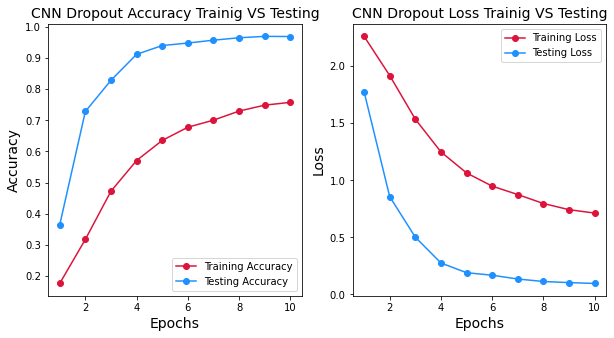

In [23]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))
axes[0].plot(range(1, len(xception_pretrained.history.history['accuracy']) + 1), xception_pretrained.history.history['accuracy'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Accuracy')
axes[0].plot(range(1, len(xception_pretrained.history.history['val_accuracy']) + 1), xception_pretrained.history.history['val_accuracy'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Accuracy')
axes[0].set_xlabel('Epochs', fontsize = 14)
axes[0].set_ylabel('Accuracy',fontsize = 14)
axes[0].set_title('CNN Dropout Accuracy Trainig VS Testing', fontsize = 14)
axes[0].legend(loc = 'best')
axes[1].plot(range(1, len(xception_pretrained.history.history['loss']) + 1), xception_pretrained.history.history['loss'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Loss')
axes[1].plot(range(1, len(xception_pretrained.history.history['val_loss']) + 1), xception_pretrained.history.history['val_loss'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Loss')
axes[1].set_xlabel('Epochs', fontsize = 14)
axes[1].set_ylabel('Loss',fontsize = 14)
axes[1].set_title('CNN Dropout Loss Trainig VS Testing', fontsize = 14)
axes[1].legend(loc = 'best')

In [32]:
y_pred = []
for n in range(num_test):
    test_img = np.array(testing_data[n][1]).reshape(-1,img_width,img_height,3)
    preds = xception_pretrained.predict(test_img)
    class_idx = np.argmax(preds[0])
    y_pred.append(class_idx)

In [33]:
preds[0]

array([4.4898002e-04, 9.6064934e-07, 2.2846144e-03, 1.2407853e-05,
       9.9493283e-01, 1.2692628e-05, 4.1889471e-06, 1.1760814e-05,
       3.7576290e-05, 2.2539478e-03], dtype=float32)

In [42]:
class_dict = {
    'c0': 'safe driving',
    'c1': 'texting - right',
    'c2': 'talking on the phone - right',
    'c3': "texting - left",
    'c4': 'talking on the phone - left',
    'c5': 'operating the radio',
    'c6': 'drinking',
    'c7': 'reaching behind',
    'c8': 'hair and makeup',
    'c9': 'talking to passenger'
}

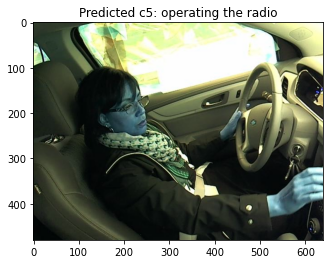

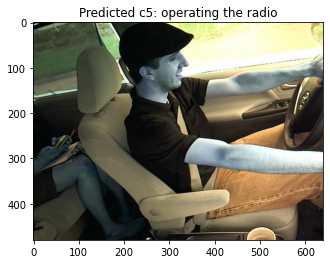

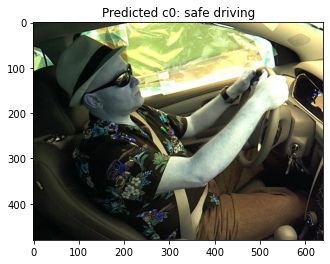

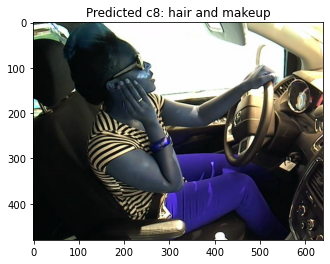

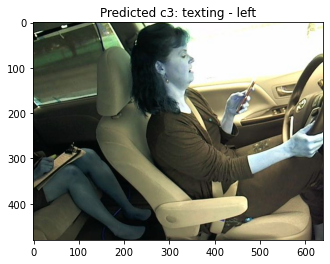

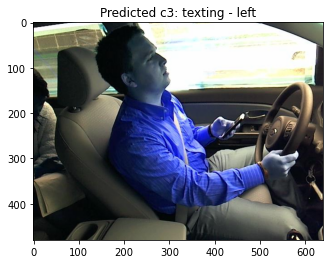

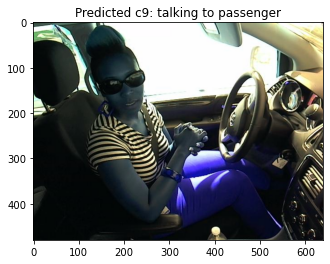

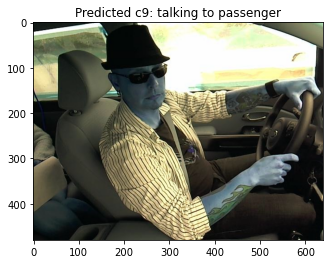

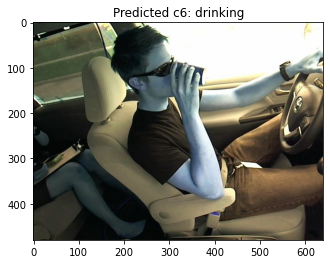

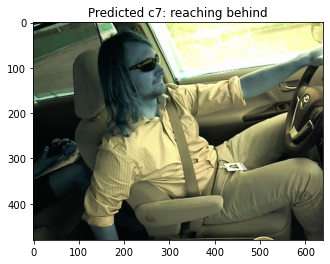

In [43]:
for n in range(10):
    img_array = cv2.imread(os.path.join(test_path, testing_data[n][0]), cv2.IMREAD_COLOR)
    plt.imshow(img_array, cmap='gray')
    title_val = y_pred[n]
    plt.title('Predicted c{}: {}'.format(title_val, class_dict['c{}'.format(title_val)]))
    plt.show()
    print('\n')